## Run the program and collect outputs

In [1]:
algos = {
    "c++11": ("./main", ["qsort", "stdsort"]),
#                          , "qsort-baseline"]),  $ ignore since it is too slow
    "java8": ("java Main", ["arrays-sort"]),
#     "python3": ("python3 main.py", ["sorted"])
}

algo_alias = {
    "qsort": "qsort",
    "stdsort": "std::sort",
    "qsort-baseline": "quickSortBaseline",
    "arrays-sort": "Arrays.sort",
    "sorted": "sorted"
}

dists = [
    "uniform-random",
    "reversed"
]

interval = "10000"
max_n    = "1000000"
N_REPEAT = 5

In [2]:
!java -version

openjdk version "1.8.0_212"
OpenJDK Runtime Environment (AdoptOpenJDK)(build 1.8.0_212-b03)
OpenJDK 64-Bit Server VM (AdoptOpenJDK)(build 25.212-b03, mixed mode)


In [3]:
!g++ --version

Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1
Apple clang version 11.0.0 (clang-1100.0.33.8)
Target: x86_64-apple-darwin19.0.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [4]:
!make
!javac Main.java

make: `main' is up to date.


In [5]:
from joblib import Parallel, delayed
import subprocess
import pickle

In [10]:
tasks = []
xyss = {}

for algo in algos:
    xyss[algo] = {}
    cmd, subalgos = algos[algo]
    for subalgo in subalgos:
        xyss[algo][subalgo] = {}
        for dist in dists:
            tasks.append((algo, cmd, subalgo, interval, max_n, dist))

In [16]:
def run_task(task):
    (algo, cmd, subalgo, interval, max_n, dist) = task
    full_cmd = "%s %s %s %s %s" % (cmd, subalgo, interval, max_n, dist)
    print("Testing (%s times) %s" % (N_REPEAT, full_cmd))
    xs = []
    ys = []
    for _ in range(N_REPEAT):
        output = subprocess.getoutput(full_cmd)
        output = output.strip().split("\n")
        try:
            xys = [tuple(l.split()) for l in output ]
            xs.extend([float(x) for x, _ in xys])
            ys.extend([float(y) for _, y in xys])
        except Exception as e:
            return (algo, subalgo, dist, None, (e, output, full_cmd))
    return (algo, subalgo, dist, xs, ys)

results = Parallel(n_jobs=12)(delayed(run_task)(task) for task in tasks)

pickle.dump(results, open("results.pkl", "wb"))

In [6]:
results = pickle.load(open("results.pkl", "rb"))

In [11]:
for result in results:
    (algo, subalgo, dist, xs, ys) = result
    if xs is None:
        (e, output, full_cmd) = ys
        print("Failed: %s\n%s\n%s" % (e, output, full_cmd))
    else:
        assert len(xs) == len(ys), (algo, subalgo, dist)
        xyss[algo][subalgo][dist] = (xs, ys)

## Plot time spent for different sizes of input

In [12]:
import matplotlib.pyplot as plt
import numpy as np

## Results I

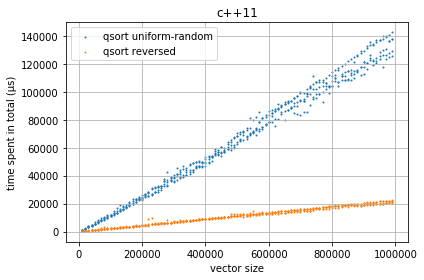

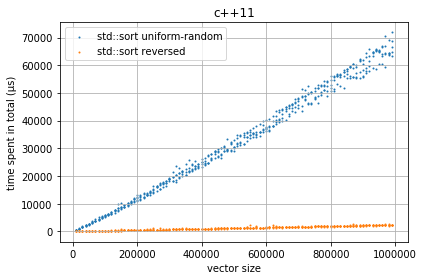

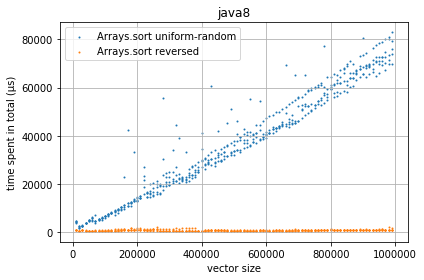

<Figure size 432x288 with 0 Axes>

In [14]:
for algo, subalgos in xyss.items():
    for subalgo, dist_xys in subalgos.items():
        plt.title(algo)
        plt.xlabel("vector size")
        plt.ylabel("time spent in total (μs)")
        for dist, xys in dist_xys.items():
            xys = zip(xys[0], xys[1])
            xys = sorted(xys, key=lambda p:p[0])
            xs = [ x for x, _ in xys ]
            ys = [ y for x, y in xys ]
            if xs is None:
                continue
            plt.scatter(xs, ys, label=algo_alias[subalgo] + " " + dist, s=1)

        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(algo + "-" + subalgo + ".png")
        plt.show()
        plt.clf()

## Results II

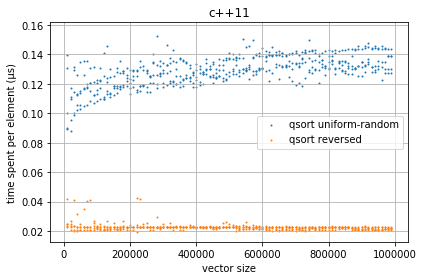

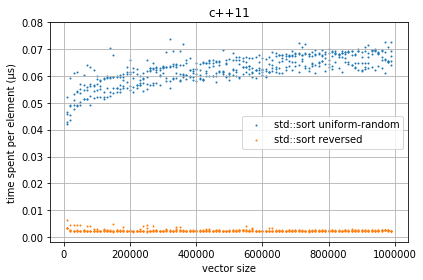

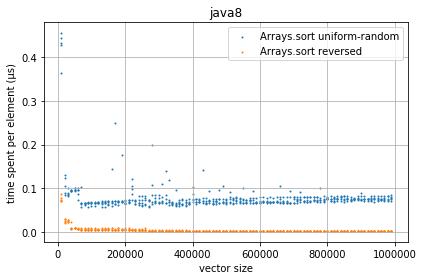

<Figure size 432x288 with 0 Axes>

In [15]:
for algo, subalgos in xyss.items():
    for subalgo, dist_xys in subalgos.items():
        plt.title(algo)
        plt.xlabel("vector size")
        plt.ylabel("time spent per element (μs)")
        for dist, xys in dist_xys.items():
            xys = zip(xys[0], xys[1])
            xys = sorted(xys, key=lambda p:p[0])
            xs = [ x for x, _ in xys ]
            ys = [ (y / x) for x, y in xys ] # the only difference compared to the code above
            if xs is None:
                continue
            plt.scatter(xs, ys, label=algo_alias[subalgo] + " " + dist, s=1)

        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig(algo + "-" + subalgo + "-ii.png")
        plt.show()
        plt.clf()